# Example: Graph generation from a gene

This notebook will show you how to use the tool to generate a KG on the underlying data.

In [1]:
import os

current_dir = os.getcwd()

os.chdir(f"{current_dir}/..")

# Set the current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

Current directory: /home/javi/code/pyBiodatafuse-2


In [2]:
# Import modules
import pickle

import pandas as pd

from pyBiodatafuse import id_mapper
from pyBiodatafuse.annotators import (
    bgee,
    disgenet,
    minerva,
    molmedb,
    opentargets,
    pubchem,
    stringdb,
    wikipathways,
)
from pyBiodatafuse.constants import BGEE_GENE_EXPRESSION_LEVELS_COL, DISGENET_DISEASE_COL
from pyBiodatafuse.graph import generator
from pyBiodatafuse.graph.rdf import generate_rdf
from pyBiodatafuse.utils import (
    combine_sources,
    create_harmonized_input_file,
    create_or_append_to_metadata,
)

### Load the input list and convert it to a dataframe

In [3]:
genes_of_interest = """AAGRN
ALG14"""

gene_list = genes_of_interest.split("\n")
len(gene_list)

2

In [4]:
data_input = pd.DataFrame(gene_list, columns=["identifier"])
data_input.head()

,identifier
0,AAGRN
1,ALG14


### Entity resolution using BridgeDB

In [5]:
os.makedirs("examples/data", exist_ok=True)

In [6]:
pickle_path = os.path.join(os.getcwd(), "examples/data/example_gene_list.pkl")
metadata_path = os.path.join(os.getcwd(), "examples/data/example_gene_list_metadata.pkl")

if not os.path.exists(pickle_path):
    bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
        identifiers=data_input,
        input_species="Human",
        input_datasource="HGNC",
        output_datasource="All",
    )
    bridgedb_df.to_pickle(pickle_path)
    with open(metadata_path, "wb") as file:
        pickle.dump(bridgedb_metadata, file)
else:
    bridgedb_df = pd.read_pickle(pickle_path)
    with open(metadata_path, "rb") as file:
        bridgedb_metadata = pickle.load(file)

In [7]:
print("Number of genes with mapping in BridgeDb:", len(bridgedb_df["identifier"].unique()))
bridgedb_df.head()

Number of genes with mapping in BridgeDb: 1


,identifier,identifier.source,target,target.source
0,ALG14,HGNC,Q96F25,Uniprot-TrEMBL
1,ALG14,HGNC,ALG14,HGNC
2,ALG14,HGNC,ENSG00000172339,Ensembl
3,ALG14,HGNC,199857,NCBI Gene
4,ALG14,HGNC,HGNC:28287,HGNC Accession Number


### Gene expression from Bgee

In [8]:
bgee_path = os.path.join(os.getcwd(), "examples/data/example_bgee.pkl")
bgee_metadata_path = os.path.join(os.getcwd(), "examples/data/example_bgee_metadata.pkl")

if not os.path.exists(bgee_path):
    bgee_df, bgee_metadata = bgee.get_gene_expression(bridgedb_df=bridgedb_df)
    bgee_df.to_pickle(bgee_path)
    with open(bgee_metadata_path, "wb") as file:
        pickle.dump(bgee_metadata, file)
else:
    bgee_df = pd.read_pickle(bgee_path)
    with open(bgee_metadata_path, "rb") as file:
        bgee_metadata = pickle.load(file)

### Disease annotatation from DisGeNet


In [9]:
import dotenv
disgenet_api_key = dotenv.dotenv_values(".env")["DISGENET_API_KEY"]

In [10]:
disgenet_path = os.path.join(os.getcwd(), "examples/data/example_disgenet.pkl")
disgenet_metadata_path = os.path.join(os.getcwd(), "examples/data/example_disgenet_metadata.pkl")

if not os.path.exists(disgenet_path):
    disgenet_df, disgenet_metadata = disgenet.get_gene_disease(
        api_key=disgenet_api_key, bridgedb_df=bridgedb_df
    )

    disgenet_df.to_pickle(disgenet_path)
    with open(disgenet_metadata_path, "wb") as file:
        pickle.dump(disgenet_metadata, file)
else:
    disgenet_df = pd.read_pickle(disgenet_path)
    with open(disgenet_metadata_path, "rb") as file:
        disgenet_metadata = pickle.load(file)

### Disease to compound annotation from OpenTargets

In [11]:
# Prepare the input to use DISGENET output as seed for OpenTargets
disease_mapping_df = create_harmonized_input_file(disgenet_df, DISGENET_DISEASE_COL, "EFO", "UMLS")
disease_mapping_df.head()

,identifier,identifier.source,target,target.source
0,UMLS_C5680989,UMLS,EFO_0700079,EFO


In [12]:
opentarget_path = os.path.join(os.getcwd(), "examples/data/example_opentarget_cmpd.pkl")
opentarget_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_opentarget_cmpd_metadata.pkl"
)

if not os.path.exists(opentarget_path):
    opentargets_df, opentargets_metadata = opentargets.get_disease_compound_interactions(
        disease_mapping_df
    )
    opentargets_df.to_pickle(opentarget_path)
    with open(opentarget_metadata_path, "wb") as file:
        pickle.dump(opentargets_metadata, file)
else:
    opentargets_df = pd.read_pickle(opentarget_path)
    with open(opentarget_metadata_path, "rb") as file:
        opentargets_metadata = pickle.load(file)

### Pathways from MINERVA

In [13]:
minerva_path = os.path.join(os.getcwd(), "examples/data/example_minerva.pkl")
minerva_metadata_path = os.path.join(os.getcwd(), "examples/data/example_minerva_metadata.pkl")

if not os.path.exists(minerva_path):
    minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(
        bridgedb_df, map_name="COVID19 Disease Map"
    )
    minerva_df.to_pickle(minerva_path)
    with open(minerva_metadata_path, "wb") as file:
        pickle.dump(minerva_metadata, file)

else:
    minerva_df = pd.read_pickle(minerva_path)
    with open(minerva_metadata_path, "rb") as file:
        minerva_metadata = pickle.load(file)

In [14]:
minerva_metadata

{'datasource': 'MINERVA',
 'metadata': {'source_version': '18.0.2'},
 'query': {'size': 1,
  'input_type': 'Ensembl',
  'MINERVA project': 'COVID19 Disease Map',
  'time': '0:02:41.304990',
  'date': '2024-11-12 17:27:23',
  'url': 'https://covid19map.elixir-luxembourg.org/minerva/'}}

### Pathways from WikiPathways

In [15]:
wikipathways_path = os.path.join(os.getcwd(), "examples/data/example_wikipathway.pkl")
wikipathways_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_wikipathway_metadata.pkl"
)

if not os.path.exists(wikipathways_path):
    wikipathways_df, wikipathways_metadata = wikipathways.get_gene_wikipathways(
        bridgedb_df=bridgedb_df
    )
    wikipathways_df.to_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "wb") as file:
        pickle.dump(wikipathways_metadata, file)

else:
    wikipathways_df = pd.read_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "rb") as file:
        wikipathways_metadata = pickle.load(file)

### Reactome pathways from OpenTargets

In [16]:
opentargets_reactome_path = os.path.join(os.getcwd(), "examples/data/example_ot_reactome.pkl")
opentargets_reactome_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_ot_reactome_metadata.pkl"
)

if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
        bridgedb_df=bridgedb_df
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)
else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

### Gene Ontology from OpenTargets

In [17]:
opentargets_go_path = os.path.join(os.getcwd(), "examples/data/example_ot_go.pkl")
opentargets_go_metadata_path = os.path.join(os.getcwd(), "examples/data/example_ot_go_metadata.pkl")

if not os.path.exists(opentargets_go_path):
    opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)
else:
    opentargets_go_df = pd.read_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

### Compounds from OpenTarget

In [18]:
opentargets_gene_path = os.path.join(os.getcwd(), "examples/data/example_ot_gene_cmpd.pkl")
opentargets_gene_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_ot_gene_cmpd_metadata.pkl"
)

if not os.path.exists(opentargets_gene_path):
    opentargets_compound_df, opentargets_compound_metadata = (
        opentargets.get_gene_compound_interactions(bridgedb_df=bridgedb_df)
    )
    opentargets_compound_df.to_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "wb") as file:
        pickle.dump(opentargets_compound_metadata, file)

else:
    opentargets_compound_df = pd.read_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "rb") as file:
        opentargets_compound_metadata = pickle.load(file)

### Transporter inhibitors from MolMeDB

In [19]:
molmedb_path = os.path.join(os.getcwd(), "examples/data/example_molmedb_gene_cmpd.pkl")
molmedb_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_molmedb_gene_cmpd_metadata.pkl"
)

if not os.path.exists(molmedb_path):
    inhibitor_df, inhibitor_metadata = molmedb.get_gene_compound_inhibitor(bridgedb_df=bridgedb_df)
    inhibitor_df.to_pickle(molmedb_path)
    with open(molmedb_metadata_path, "wb") as file:
        pickle.dump(inhibitor_metadata, file)
else:
    inhibitor_df = pd.read_pickle(molmedb_path)
    with open(molmedb_metadata_path, "rb") as file:
        inhibitor_metadata = pickle.load(file)
inhibitor_df.head(1)

""


### Screening results of compounds on proteins encoded by genes annotation by PubChem

In [20]:
pubchem_path = os.path.join(os.getcwd(), "examples/data/example_pubchem.pkl")
pubchem_metadata_path = os.path.join(os.getcwd(), "examples/data/example_pubchem_metadata.pkl")

if not os.path.exists(pubchem_path):
    pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(
        bridgedb_df=bridgedb_df
    )
    pubchem_assay_df.to_pickle(pubchem_path)
    with open(pubchem_metadata_path, "wb") as file:
        pickle.dump(pubchem_assay_metadata, file)

else:
    pubchem_assay_df = pd.read_pickle(pubchem_path)
    with open(pubchem_metadata_path, "rb") as file:
        pubchem_assay_metadata = pickle.load(file)

### Protein-Protein interactions from STRING

In [21]:
string_path = os.path.join(os.getcwd(), "examples/data/example_string.pkl")
string_metadata_path = os.path.join(os.getcwd(), "examples/data/example_string_metadata.pkl")

if not os.path.exists(string_path):
    ppi_df, ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
    ppi_df.to_pickle(string_path)
    with open(string_metadata_path, "wb") as file:
        pickle.dump(ppi_metadata, file)
else:
    ppi_df = pd.read_pickle(string_path)
    with open(string_metadata_path, "rb") as file:
        ppi_metadata = pickle.load(file)

### Combing all the results into single dataframe

In [22]:
combined_df = combine_sources(
    bridgedb_df,
    [
        bgee_df,
        disgenet_df,
        minerva_df,
        wikipathways_df,
        opentargets_reactome_df,
        opentargets_go_df,
        opentargets_compound_df,
        inhibitor_df,
        pubchem_assay_df,
        ppi_df,
    ],
)
combined_df.head()

,identifier,identifier.source,target,target.source,Bgee_gene_expression_levels,DISGENET_diseases,WikiPathways,OpenTargets_reactome,OpenTargets_go
0,ALG14,HGNC,ENSG00000172339,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Carbohydrate Deficient Glyc...,"[{'pathway_id': 'WP:WP5153', 'pathway_label': ...",[{'pathway_label': 'Biosynthesis of the N-glyc...,"[{'go_id': 'GO:0043541', 'go_name': 'UDP-N-ace..."


In [23]:
inhibitor_df.head(1)

""


In [24]:
combined_df.shape

(1, 9)

In [25]:
combined_df.to_pickle("examples/data/combined_df.pkl")

In [26]:
# Shuffling the rows
import numpy as np

combined_df["DISGENET_diseases"] = combined_df["DISGENET_diseases"].apply(np.random.permutation)

In [27]:
combined_metadata = create_or_append_to_metadata(
    bridgedb_metadata,
    [
        bgee_metadata,
        disgenet_metadata,
        opentargets_metadata,
        opentargets_compound_metadata,
        inhibitor_metadata,
        pubchem_assay_metadata,
        ppi_metadata,
        wikipathways_metadata,
        minerva_metadata,
        opentargets_reactome_metadata,
        opentargets_go_metadata,
    ],
)

### Exporting the database in pickle format

In [28]:
combined_df.to_pickle("examples/data/example_df_shuffled.pkl")

with open("example_metadata.pkl", "wb") as out:
    pickle.dump(combined_metadata, out)

with open("opentargets_disease_compound_df.pkl", "wb") as out:
    pickle.dump(opentargets_metadata, out)

## Creating a graph from the annotated dataframe

In [29]:
pygraph = generator.save_graph(
    combined_df=combined_df,
    combined_metadata=combined_metadata,
    disease_compound=opentargets_df,
    graph_name="examples",
    graph_dir="./data",
)

Combined DataFrame saved in ./data/examples/examples_df.pkl
Metadata saved in ./data/examples/examples_metadata.pkl
Building graph: 100%|██████████| 1/1 [00:00<00:00, 441.60it/s]
Graph is built successfully
Graph saved in ./data/examples/examples_graph.pkl and ./data/examples/examples_graph.gml


#### Cytosacpe
Make sure that the Cytoscape is open

In [30]:
# from pyBiodatafuse.graph import cytoscape

# cytoscape.load_graph(pygraph, network_name="Test network")

#### Neo4j

In [31]:
from pyBiodatafuse.graph import neo4j

neo4j.save_graph_to_graphml(pygraph, "networkx_graph_test.graphml")

##### Steps to load the graph in Neo4j

- Add `.graphml` file in **import** subfolder of the DBMS folder
- Install apoc plugin
- Create `apoc.conf` file:
    ```
    apoc.trigger.enabled=true
    apoc.import.file.enabled=true
    apoc.export.file.enabled=true
    apoc.import.file.use_neo4j_config=true
    ```
- Add `apoc.conf` file to **conf** subfolder of the DBMS folder
- Open Neo4j Browser
- (Optionl, only run if you have imported a graph  before) Remove all the nodes before importing `.graphml` file

    ```MATCH (n) DETACH DELETE n```

- Import `.graphml` file

    ```call apoc.import.graphml('file:///networkx_graph_test.graphml',{readLabels:TRUE})```

- Add indexes after importing the graph for improving the performance of queries

    ```
    create index Gene for (n:Gene) on (n.node_type)
    create index Pathway for (n:Pathway) on (n.node_type)
    create index `Biological Process` for (n:`Biological Process`) on (n.node_type)
    create index `Molecular Function` for (n:`Molecular Function`) on (n.node_type)
    create index `Cellular Component` for (n:`Cellular Component`) on (n.node_type)
    create index Disease for (n:Disease) on (n.node_type)
    create index Compound for (n:Compound) on (n.node_type)
    create index `Side Effect` for (n:`Side Effect`) on (n.node_type)
    ```
    

- Count the number of each node type
    - total (```MATCH (n) RETURN count(n)```) 
        - Gene (```MATCH (n:Gene) RETURN count(n)```)
        - Pathway (```MATCH (n:Pathway) RETURN count(n)```)
            - WikiPathways (```MATCH (n:Pathway {source: "WikiPathways"}) RETURN count(n)```) 
            - OpenTargets, Reactome (```MATCH (n:Pathway {source: "OpenTargets"}) RETURN count(n)```) 
            - MINERVA (```MATCH (n:Pathway {source: "MINERVA"}) RETURN count(n)```) 
        - Biological Process (```MATCH (n:`Biological Process`) RETURN count(n)```) 
        - Molecular Function (```MATCH (n:`Molecular Function`) RETURN count(n)```) 
        - Cellular Component (```MATCH (n:`Cellular Component`) RETURN count(n)```) 
        - Disease (```MATCH (n:Disease) RETURN count(n)```) 
        - Compound (```MATCH (n:Compound) RETURN count(n)```)
        - Side Effect (```MATCH (n:`Side Effect`) RETURN count(n)```) 
- Count the number of each edge type
    - total (```MATCH ()-[r]->() RETURN count(r)```) 
        - interacts_with (```MATCH ()-[r:interacts_with]->() RETURN count(r)```) 
        - part_of (```MATCH ()-[r:part_of]->() RETURN count(r)```) 
            - WikiPathways (```MATCH ()-[r:part_of {source: "WikiPathways"}]->() RETURN count(r)```) 
            - OpenTargets, Reactome (```MATCH ()-[r:part_of {source: "OpenTargets"}]->() RETURN count(r)```) 
            - MINERVA (```MATCH ()-[r:part_of {source: "MINERVA"}]->() RETURN count(r)```) 
        - activates (```MATCH ()-[r:activates]->() RETURN count(r)```) 
        - treats (```MATCH ()-[r:treats]->() RETURN count(r)```) 
        - has_side_effect (```MATCH ()-[r:has_side_effect]->() RETURN count(r)```) 
        - inhibits (```MATCH ()-[r:inhibits]->() RETURN count(r)```) = 71
        - associated_with (```MATCH ()-[r:associated_with]->() RETURN count(r)```) 

- Export the graph as a `.csv` file

    ```call apoc.export.csv.all("networkx_graph_test.csv",{})```

### RDF

In [32]:
g = generate_rdf(
    df=combined_df,
    base_uri="https://biodatafuse.org/example/",
    version_iri="https://biodatafuse.org/example/test.owl",
    orcid="https://orcid.org/0000-0002-4166-7093",
    author="Javier Millan Acosta",
    metadata=None,
    open_only=True,
    load_ontology=False,
)

In [33]:
g.serialize("BDF_example_graph.ttl", format="ttl")

<Graph identifier=Nb722d0a9f41e4afca140144a0aef515f (<class 'rdflib.graph.Graph'>)>

### Use [`shexer`](https://github.com/DaniFdezAlvarez/shexer/) to retrieve the RDF shapes

The `shexer` package is wrapped in `get_shapes()` and allows us to retrieve the shapes of the graph in ShEx (https://shex.io/shex-semantics/) and SHACL (https://www.w3.org/TR/shacl/).

In [34]:
from pyBiodatafuse.graph.rdf.utils import get_shapes

shex_shapes = get_shapes(g=g, 
                  base_uri="https://biodatafuse.org/example/", 
                  uml_figure_path="shex.png",
                  graph_type="shex",  # Default value
                  path="BDF_example_shex.ttl",
                  print_string_output=False
                  )
shacl_shapes = get_shapes(
    g=g,
    base_uri="https://biodatafuse.org/example/",
    uml_figure_path="shacl.png",
    graph_type="shacl",  # Default value
    path="BDF_example_shacl.ttl",
    print_string_output=False,
)

#### SHEX

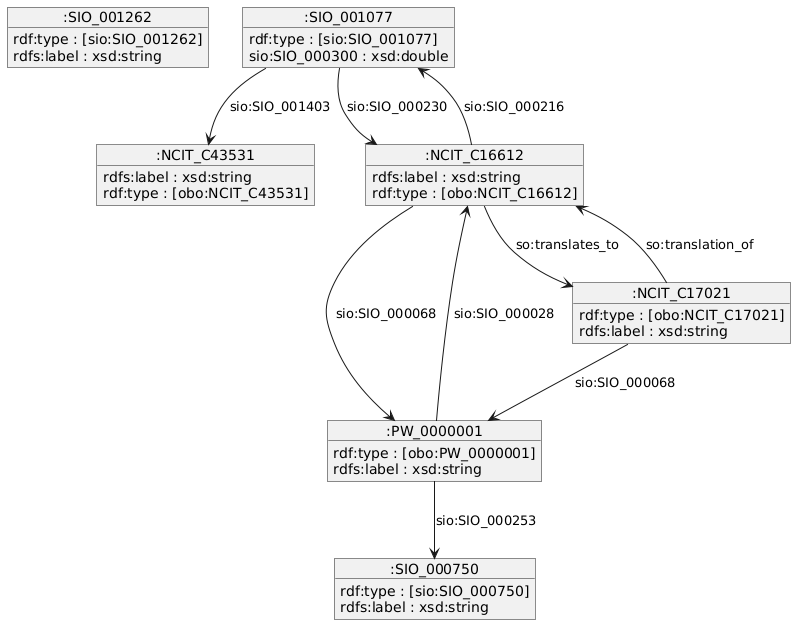

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example.org/>
PREFIX : <http://weso.es/shapes/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX graph: <https://biodatafuse.org/example/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX so: <http://purl.obolibrary.org/obo/so#>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <h

In [43]:
from IPython.display import Image, Markdown, display
display(Markdown('#### SHEX'))
display(Image("shex.png"))
print(shex_shapes)

#### SHACL

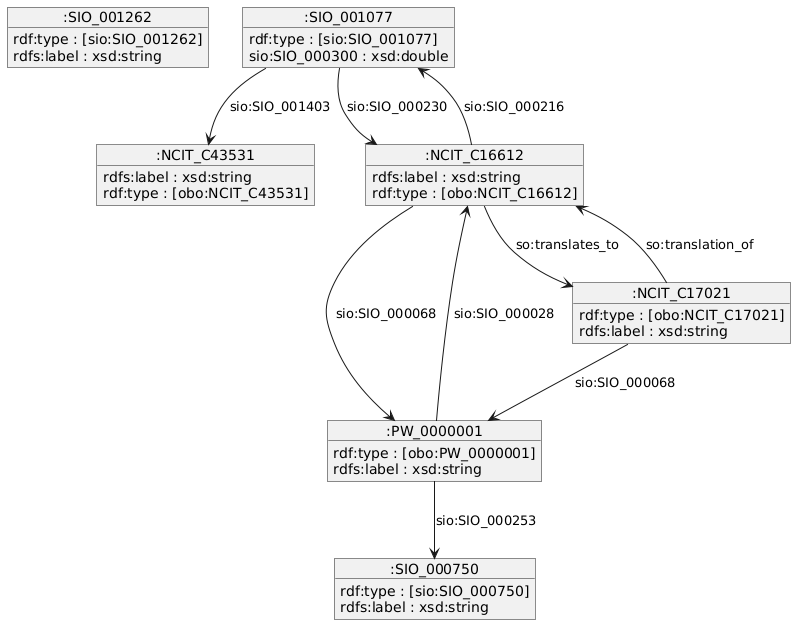

@prefix : <http://weso.es/shapes/> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix so: <http://purl.obolibrary.org/obo/so#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:NCIT_C43531 a sh:NodeShape ;
    sh:property [ a sh:PropertyShape ;
            sh:in ( obo:NCIT_C43531 ) ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path rdf:type ],
        [ a sh:PropertyShape ;
            sh:dataType xsd:string ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path rdfs:label ] ;
    sh:targetClass obo:NCIT_C43531 .

:NCIT_C17021 a sh:NodeShape ;
    sh:property [ a sh:PropertyShape ;
            sh:in ( obo:NCIT_C17021 ) ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path rdf:type ],
     

In [44]:
display(Markdown("#### SHACL"))
display(Image("shacl.png"))
print(shacl_shapes)

### SPARQL queries

This section displays some of the sample queries included in [SPARQL/queries.ttl](SPARQL/queries.ttl), loaded in a Virtuoso instance at http://localhost:8899/sparql.

In [37]:
import requests


def send_sparql_query(query, endpoint="http://localhost:8899/sparql", format="text/csv"):
    headers = {"Accept": format}
    params = {"query": query}
    response = requests.get(endpoint, headers=headers, params=params)

    # Check if request was successful
    if response.status_code == 200:
        if format == "text/csv":
            # Convert CSV response to pandas DataFrame
            from io import StringIO

            csv_data = StringIO(response.text)
            return pd.read_csv(csv_data)
        else:
            return response.text  # For other formats if needed
    else:
        raise Exception(f"Query failed with status code {response.status_code}: {response.text}")

In [38]:
from rdflib import RDF, RDFS, SH, Graph

# Load the graph
os.chdir("examples")
query_g = Graph()
with open("SPARQL/queries.ttl", "r") as f:
    query_g.parse(f, format="turtle")

# Extract queries and comments into a list of dictionaries
queries_list = []
for s in query_g.subjects(RDF.type, SH.SPARQLSelectExecutable):
    query_text = query_g.value(s, SH.select)
    comment = query_g.value(s, RDFS.comment)

    if query_text and comment:
        # Append a dictionary for each query and its comment
        queries_list.append({"comment": comment.value, "query": query_text.value})

In [39]:
query_0 = send_sparql_query(queries_list[0]["query"])
print(queries_list[0]["comment"])
print(queries_list[0]["query"])
query_0

Retrieve details about each gene in the dataset, including the pathways it participates in, and the expression levels tied to it together with its associated anatomical entity and developmental stage. Return the text labels for all entities.

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?gene ?geneLabel ?pathway ?pathwayLabel ?expressionMetric ?expressionValue ?anatomicalEntity ?anatomicalEntityLabel ?developmentalStage ?developmentalStageLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?pathway ;
          sio:SIO_000216 ?expressionMetric ;
          rdfs:label ?geneLabel .
    ?anatomicalEntity rdfs:label ?anatomicalEntityLabel ;
          a sio:SIO_001262 .
    ?developmentalStage rdfs:label ?developmentalStageLabel ;
          a obo:NCIT_C43531 .
    ?expressionMetric sio:SIO_000300 ?expressionValue ;
          sio:SIO_001403 ?anatomicalEntity ;
     

,gene,geneLabel,pathway,pathwayLabel,expressionMetric,expressionValue,anatomicalEntity,anatomicalEntityLabel,developmentalStage,developmentalStageLabel


In [40]:
query_1 = send_sparql_query(queries_list[1]["query"])
print(queries_list[1]["comment"])
print(queries_list[1]["query"])
query_1

Identify pathways described to involve more than seven genes, and show which sources provide data on these gene-pathway associations. Return the genes as well.

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?pathway ?pathwayLabel (COUNT(?gene) AS ?geneCount) (GROUP_CONCAT(DISTINCT ?sourceLabel; separator=", ") AS ?sources)  (GROUP_CONCAT(DISTINCT ?geneLabel; separator=", ") AS ?genes)
WHERE {
    ?pathway a obo:PW_0000001 ;
             sio:SIO_000028 ?gene ;
             sio:SIO_000253 ?source ;
             rdfs:label ?pathwayLabel .
    ?gene a obo:NCIT_C16612 ;
            rdfs:label ?geneLabel .
    ?source rdfs:label ?sourceLabel .
} 
GROUP BY ?pathway ?pathwayLabel
HAVING (COUNT(?gene) > 7)



,pathway,pathwayLabel,geneCount,sources,genes


In [41]:
query_2 = send_sparql_query(queries_list[2]["query"])
print(queries_list[2]["comment"])
print(queries_list[2]["query"])
query_2

Show the protein products of all genes as well as any pathways they are part of. Return the molecular functions these genes hace been described to perform. Don't return labels, except for pathways and molecular functions.

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

SELECT DISTINCT ?protein ?gene ?pathway ?pathwayLabel ?molecularFunction ?molecularFunctionLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
                 rdfs:label ?geneLabel ;
                 sio:SIO_000068 ?pathway ;
                 sio:SIO_000068 ?molecularFunction .
    ?molecularFunction rdfs:subClassOf obo:GO_0003674 ;
                 rdfs:label ?molecularFunctionLabel .
    ?protein a obo:NCIT_C17021 ;
             pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel .
    ?pathway a obo:PW_0000001 ;
             rdfs:label ?pathwayLabel .
}


,protein,gene,pathway,pathwayLabel,molecularFunction,molecularFunctionLabel


In [42]:
query_3 = send_sparql_query(queries_list[3]["query"])
print(queries_list[3]["query"])
print(queries_list[3]["comment"])
query_3


PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?gene ?geneLabel ?expressionValue ?anatomicalEntity ?entityLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000216 ?expressionMetric ;
          rdfs:label ?geneLabel .

          
    ?expressionMetric a sio:SIO_001077 ;
                      sio:SIO_001403 ?anatomicalEntity ;
                      sio:SIO_000300 ?expressionValue ;
                      sio:SIO_001403 obo:UBERON_0000104 .
    ?anatomicalEntity a sio:SIO_001262 ;
                      rdfs:label ?anatomicalEntityLabel .
}
ORDER BY DESC(?expressionValue)
List genes linked to that have been found to be expressed in blood, along with their expression level values. Sort them in descending order according to their expression level values. Return all relevant labels.


,gene,geneLabel,expressionValue,anatomicalEntity,entityLabel
